##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Sufficient Input Subsets Tutorial on MNIST

Sufficient Input Subsets (SIS for short) is a local explanation framework interpreting black-box functions.
A sufficient input subset is a minimal set of input features whose observed values alone suffice for the same decision to
be reached, even with all other input values missing. These subsets can be understood as rationales for a model's decision-making.
See the [SIS paper](https://arxiv.org/abs/1810.03805) for more details.

This notebook gives a simple example for using SIS in practice.
In this tutorial we:

* Train a CNN to classify MNIST handwritten digits
* Apply SIS to produce explanations for the model's decisions
* Apply SIS to misclassified digits, to understand why the model made certain misclassifications

In [0]:
from __future__ import print_function

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from sufficient_input_subsets import sis

# Download MNIST

In [0]:
# Load MNIST and convert from integers to floats.

mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

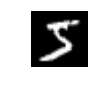

In [0]:
# Visualize an example digit.

image = x_train[0]

plt.figure(figsize=(1, 1))
plt.imshow(image[:, :, 0], cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

# Train an MNIST Digit Classifier

We train a simple convolutional neural network (CNN) (taken from the Keras MNIST CNN
[example](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py)) to classify MNIST
handwritten digits

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                         input_shape=(28, 28, 1), data_format='channels_last'),
  tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# Train and evaluate model.

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test, y_test)

Epoch 1/5
60000/60000 [==============================] - 7s 110us/step - loss: 0.1847 - acc: 0.9445
Epoch 2/5
60000/60000 [==============================] - 7s 110us/step - loss: 0.0796 - acc: 0.9763
Epoch 3/5
60000/60000 [==============================] - 7s 115us/step - loss: 0.0586 - acc: 0.9822
Epoch 4/5
60000/60000 [==============================] - 7s 120us/step - loss: 0.0499 - acc: 0.9842
Epoch 5/5
10000/10000 [==============================] - 0s 41us/step - loss: 0.0312 - acc: 0.9909


[0.031191634417892054, 0.99089998]

# Run SIS to Produce Explanations

We now apply SIS to understand the model's decisions on particular examples of digit 4. First, we will find images from the test set which the model classifies as 4 with high confidence. Then, we will compute and visualize the SIS-collection for some of these images.

By default, we follow the SIS paper and use a threshold of 0.7 ($\tau = 0.7$) and mask pixels by
replacement with the mean pixel taken over the training images.

Feel free to explore different values of these parameters and observe the effects on the SIS!




Running SIS on 5 examples of digit 4. This might take a couple minutes.


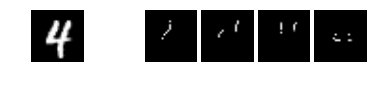

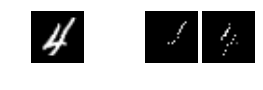

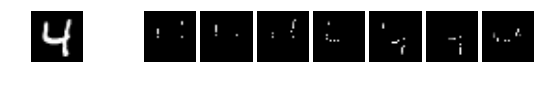

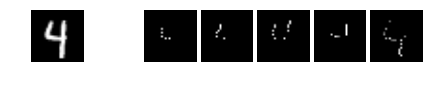

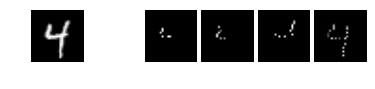

In [0]:
#@title Select a digit and threshold {run: "auto"}

DIGIT = 4  #@param ['0', 1', '2', '3', '4', '5', '6', '7', '8', '9'] {type:"raw"}

THRESHOLD = 0.7  #@param {type:"slider", min:0, max:1, step:0.1}

# Following the SIS paper, we use the mean pixel from training images as a mask.
FULLY_MASKED_IMAGE = np.full((28, 28, 1), np.mean(x_train))

# Helper function that selects the probability for a single class, from the
# softmax output.
def make_f_for_digit(digit, model):
  def f_digit(batch_of_inputs):
    return model.predict(
        batch_of_inputs, batch_size=min(784, len(batch_of_inputs)))[:, digit]
  return f_digit

# This function maps a list of images to a list of probabilities (probability of
# each image being a 4).
f_digit = make_f_for_digit(DIGIT, model)

# Helper function that filters input images to those the model predicts with
# high confidence (f(image) >= threshold).
def select_images_for_sis(inputs, f_digit, threshold):
  preds = f_digit(inputs)
  idxs = np.nonzero(preds >= threshold)[0]
  return inputs[idxs]

# Filter test images that the model classifies as 4 with high confidence.
high_confidence_images_for_digit = select_images_for_sis(x_test, f_digit,
                                                         THRESHOLD)

# Randomly select some of these digits to run SIS.
digits_to_run_sis = high_confidence_images_for_digit[
    np.random.choice(high_confidence_images_for_digit.shape[0],
                     size=5,
                     replace=False)]

# Helpers for plotting an MNIST digit and its corresponding SIS-collection.
def plot_mnist_digit(ax, image):
  ax.imshow(image[:, :, 0], cmap=plt.get_cmap('gray'))
  ax.axis('off')

def plot_sis_collection(initial_image, collection, fully_masked_image):
  # Grid contains initial image, an empty cell (for spacing), and collection.
  width = len(collection) + 2
  plt.figure(figsize=(width, 1))
  gs = plt.GridSpec(1, width, wspace=0.1)

  # Plot initial image.
  ax = plt.subplot(gs[0])
  plot_mnist_digit(ax, initial_image)

  # Plot each SIS.
  for i, sis_result in enumerate(collection):
    ax = plt.subplot(gs[i+2])
    masked_image = sis.produce_masked_inputs(initial_image, fully_masked_image,
                                             [sis_result.mask])[0]
    plot_mnist_digit(ax, masked_image)

  plt.show()

print('Running SIS on {} examples of digit {}. '
      'This might take a couple minutes.'.format(len(digits_to_run_sis), DIGIT))

# Run SIS on each digit and visualize the resulting SIS-collections.
for initial_image in digits_to_run_sis:
  collection = sis.sis_collection(f_digit, THRESHOLD, initial_image,
                                  FULLY_MASKED_IMAGE)
  plot_sis_collection(initial_image, collection, FULLY_MASKED_IMAGE)

# Using SIS to Understand Misclassifications

We now explore how SIS can be used to understand misclassifications.

First, we will search for images from the test set (of any class) which the CNN misclassifies with high confidence. Then, we will compute and print the corresponding SIS-collections for some of these images to see the rationales to better understand why the model made these misclassifications.

Running SIS on 10 misclassified digits. This might take a couple minutes.

True label:     5
Classified as:  3


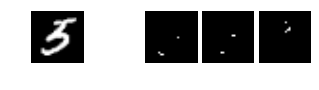

True label:     4
Classified as:  6


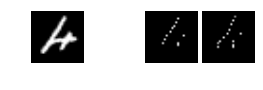

True label:     8
Classified as:  0


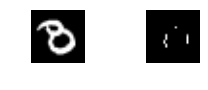

True label:     7
Classified as:  3


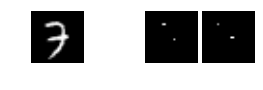

True label:     1
Classified as:  6


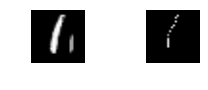

True label:     9
Classified as:  8


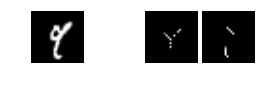

True label:     4
Classified as:  9


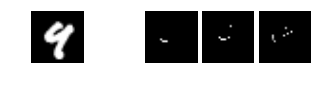

True label:     4
Classified as:  8


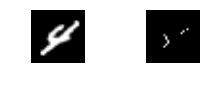

True label:     6
Classified as:  4


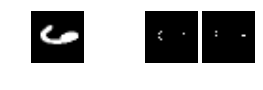

True label:     7
Classified as:  3


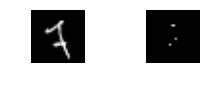

In [0]:
#@title Choose number of misclassified digits and threshold {run: "auto"}

NUM_MISCLASSIFIED = 10  #@param {type:"integer"}

THRESHOLD = 0.7  #@param {type:"slider", min:0, max:1, step:0.1}

# Find images the model misclassifies with high confidence.
y_test_preds = model.predict(x_test)
y_test_classes = y_test_preds.argmax(axis=1)

misclassified_idxs = np.nonzero(y_test != y_test_classes)[0]
misclassified_confidences = y_test_preds[misclassified_idxs].max(axis=1)

misclassified_with_high_confidence_idxs = misclassified_idxs[
    np.nonzero(misclassified_confidences >= THRESHOLD)[0]]

print('Running SIS on {} misclassified digits. '
      'This might take a couple minutes.\n'.format(NUM_MISCLASSIFIED))

# Randomly select some misclassificiations to run SIS.
misclassified_idxs_to_run_sis = misclassified_with_high_confidence_idxs[
    np.random.choice(
       misclassified_with_high_confidence_idxs.shape[0],
       size=NUM_MISCLASSIFIED,
       replace=False)]

# Run SIS on these images and visualize the corresponding SIS-collections.
for idx in misclassified_idxs_to_run_sis:
  initial_image = x_test[idx]

  true_label = y_test[idx]
  predicted_label = y_test_classes[idx]

  print('True label:    ', true_label)
  print('Classified as: ', predicted_label)

  f_predicted_label = make_f_for_digit(predicted_label, model)
  collection = sis.sis_collection(f_predicted_label, THRESHOLD, initial_image,
                                  FULLY_MASKED_IMAGE)

  plot_sis_collection(initial_image, collection, FULLY_MASKED_IMAGE)

These images allow us to understand ***why*** the model made these misclassifications!